In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from labellines import labelLine, labelLines

In [65]:
index_data = {
    'N50': pd.read_csv('./jan_2024_data/N50.csv')[::-1],
#    'N50V20': pd.read_csv('./jan_2024_data/N50V20.csv')[::-1],
    'N50_EQ_WT': pd.read_csv('./jan_2024_data/N50_EQ_WT.csv')[::-1],
    'NN50': pd.read_csv('./jan_2024_data/NN50.csv')[::-1],
    'Midcap150': pd.read_csv('./jan_2024_data/Midcap150.csv')[::-1],
    'AlphaLowVol': pd.read_csv('./jan_2024_data/AlphaLowVol.csv')[::-1],
    'Midcap150Quality50': pd.read_csv('./jan_2024_data/Midcap150Quality50.csv')[::-1],
    'N200Momentum30': pd.read_csv('./jan_2024_data/N200Momentum30.csv')[::-1],
    'Midcap150M50': pd.read_csv('./jan_2024_data/Midcap150M50.csv')[::-1],
    'Smallcap250MQ100': pd.read_csv('./jan_2024_data/Smallcap250MQ100.csv')[::-1]
}

In [66]:
## Some dates are repeated in - Midcap150Quality50 with slightly different values for each day
## We fix this by taking the average close value for that day and using that

# Assuming index_data is already defined
df = index_data['Midcap150Quality50']

# Identify the columns
date_column = 'Date'  # replace with the actual name or index of your date column if different
value_column = 'Close'  # the column for which you want the mean

# Create a temporary DataFrame to store the unique dates and their original order
temp_df = df[[date_column]].drop_duplicates(keep='first')
temp_df['temp_order'] = range(len(temp_df))

# Group by the date column, then calculate the mean of the value column for each group
df_mean = df.groupby(date_column, as_index=False)[value_column].mean()

# Merge the mean values back into the original DataFrame
df = df.merge(df_mean, on=date_column, suffixes=('', '_mean'))

# Replace the original 'Close' values with the mean values
df[value_column] = df[value_column + '_mean']
df = df.drop(columns=[value_column + '_mean'])

# Merge the temporary DataFrame to restore the original order
df = df.merge(temp_df, on=date_column)

# Sort by the original order and drop the 'temp_order' column
df = df.sort_values('temp_order').drop(columns=['temp_order'])

# Drop duplicate dates, keeping the first occurrence
df = df.drop_duplicates(subset=date_column, keep='first')

# Optionally, save the modified DataFrame back to a CSV file
df[::-1].to_csv('./jan_2024_data/Midcap150Quality50_modified.csv', index=False)

# Update the 'Midcap150Quality50' entry in index_data with the modified DataFrame
df.index = range(len(df)-1, -1, -1)
index_data['Midcap150Quality50'] = df

## ToDo
Some index data (e.g. 200Momentum30) now only return values from 2019 or 2020 onwards. For those cases, our earlier downloaded data (in raw_data/) __needs to be appended manually to make the whole set.__

In [67]:
# all indexes should have same number of rows (Midcap150Quality50 has missing data for 9 rows, sent email to indices@nse.co.in)

for key, df in index_data.items():
    print(f"{key}: {df.shape}")

N50: (4670, 6)
N50_EQ_WT: (4670, 6)
NN50: (4670, 6)
Midcap150: (4670, 6)
AlphaLowVol: (4670, 6)
Midcap150Quality50: (4661, 6)
N200Momentum30: (4670, 6)
Midcap150M50: (4670, 6)
Smallcap250MQ100: (4670, 6)


In [75]:
volatilities = {}

for key, data in index_data.items():
    volatilities[key] = data.Close.pct_change().std() * 252 ** 0.5

for index, volatility in sorted(volatilities.items(), key=lambda item: item[1]):
    print(index + (33 - len(index)) * ' ' + '=> ' + str(volatility))

AlphaLowVol                      => 0.17672033760754133
Midcap150Quality50               => 0.17860626529691528
Midcap150                        => 0.21192061650979147
Midcap150M50                     => 0.2122369521356147
N50_EQ_WT                        => 0.21440654396175884
N50                              => 0.21507403854663976
Smallcap250MQ100                 => 0.21729047555048228
N200Momentum30                   => 0.2261328128264018
NN50                             => 0.2325861976732588


In [74]:
import numpy as np

volatilities = {}

# Assuming each row in your DataFrame corresponds to one year
years_per_period = 10

for key, data in index_data.items():
    if 'Close' in data.columns:
        # Calculate CAGR for each 10-year rolling period
        cagr = ((data['Close'].shift(-years_per_period + 1) / data['Close']) ** (1/years_per_period)) - 1
        
        # Drop NaN values that result from the rolling calculation
        cagr = cagr.dropna()
        
        # Calculate standard deviation of the CAGR values and convert to percentage
        volatilities[key] = cagr.std() * 100
    else:
        # Handle the case where 'Close' column is not present
        volatilities[key] = None

# Sort the results by volatility, lowest first
sorted_volatilities = sorted(volatilities.items(), key=lambda item: (item[1] is not None, item[1]))

for index, volatility in sorted_volatilities:
    if volatility is not None:
        print(f"{index:<33} => {volatility:.2f}%")
    else:
        print(f"{index:<33} => 'Close' column not found")

AlphaLowVol                       => 0.36%
Midcap150Quality50                => 0.40%
N50                               => 0.41%
N50_EQ_WT                         => 0.43%
N200Momentum30                    => 0.44%
Midcap150M50                      => 0.47%
Midcap150                         => 0.49%
NN50                              => 0.49%
Smallcap250MQ100                  => 0.52%


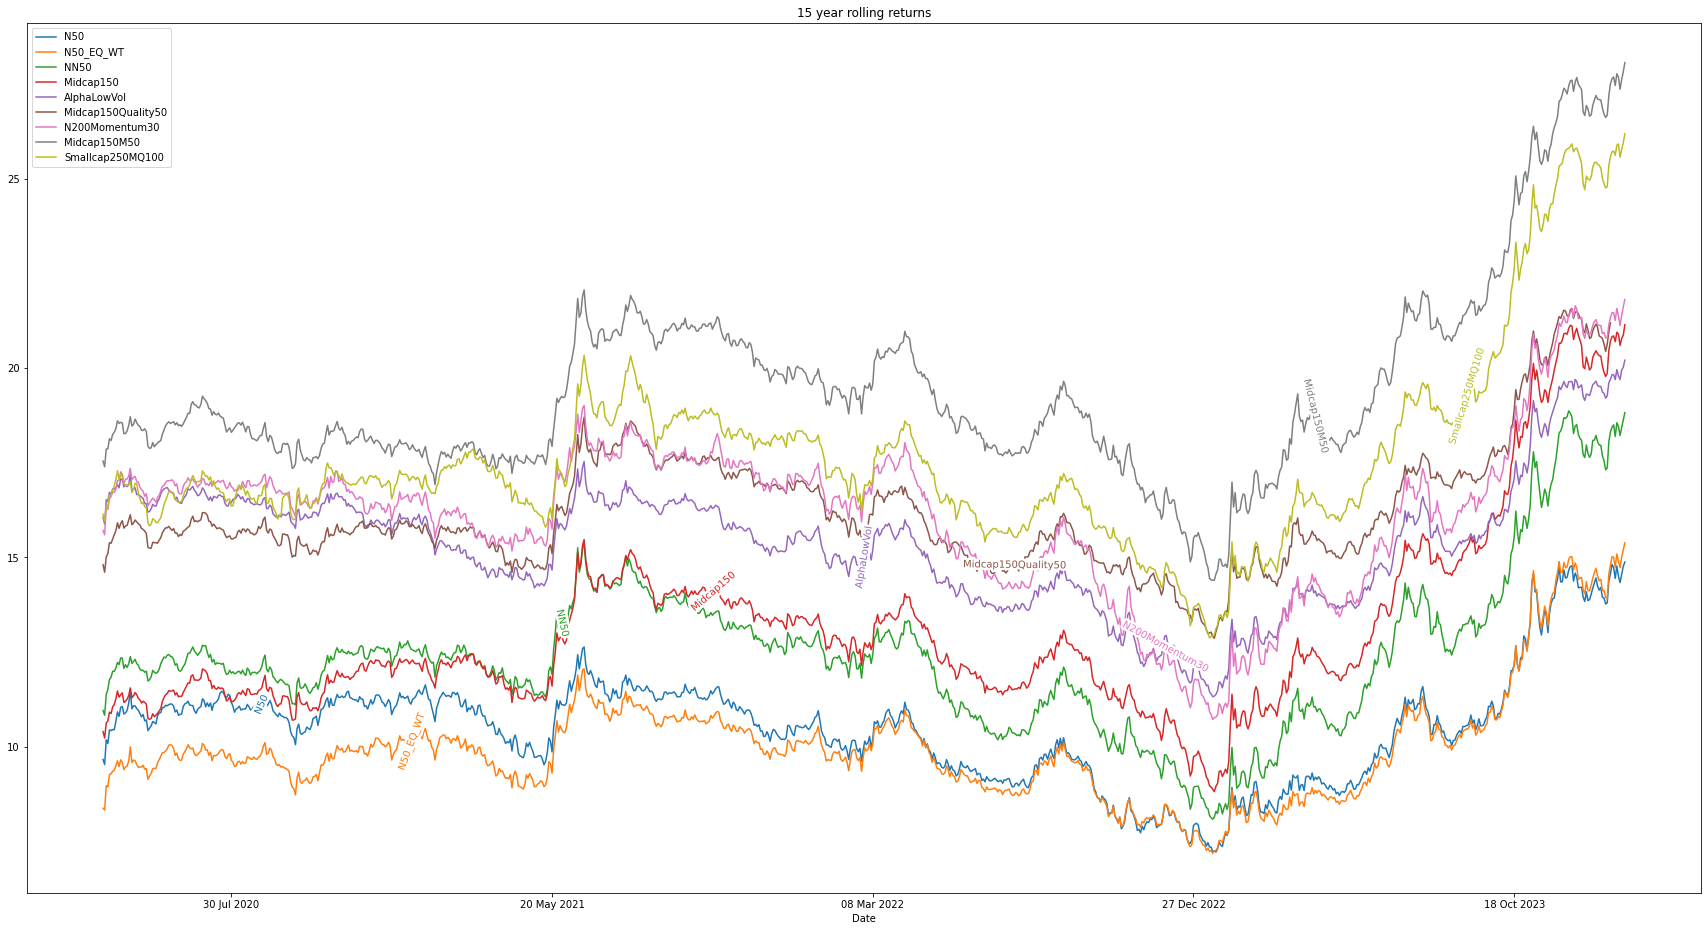

In [77]:
import copy
import mplcursors

days = 248  # avg. # of trading days in a year
years = 15
title = str(years) + ' year rolling returns'

returns = copy.deepcopy(index_data)
ax = None

for key, data in index_data.items():
    returns[key][key] = ((1 + data.Close.pct_change(periods= days * years)) ** (1 / years) - 1) * 100

for key, data in returns.items():
    if ax is None:
        ax = data.plot.line(x='Date', y=key, figsize=(30,16), title=title)
    else:
        data.plot.line(x='Date', y=key, ax=ax)   

ax.labelsize = 'large'
labelLines(plt.gca().get_lines(), zorder=5.5)
cursor1 = mplcursors.cursor(ax.lines)